## Set-up environment

Let's start by installing [EasyOCR](https://github.com/JaidedAI/EasyOCR) (an open-source OCR engine). 

In [1]:
!pip install -q easyocr


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## Load model

Next, we load a Table Transformer pre-trained for table detection. We use the "no_timm" version here to load the checkpoint with a Transformers-native backbone.

In [2]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [3]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

We move the model to a GPU if it's available (predictions will be faster).

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

## Load image

Next, we can load a PDF image.

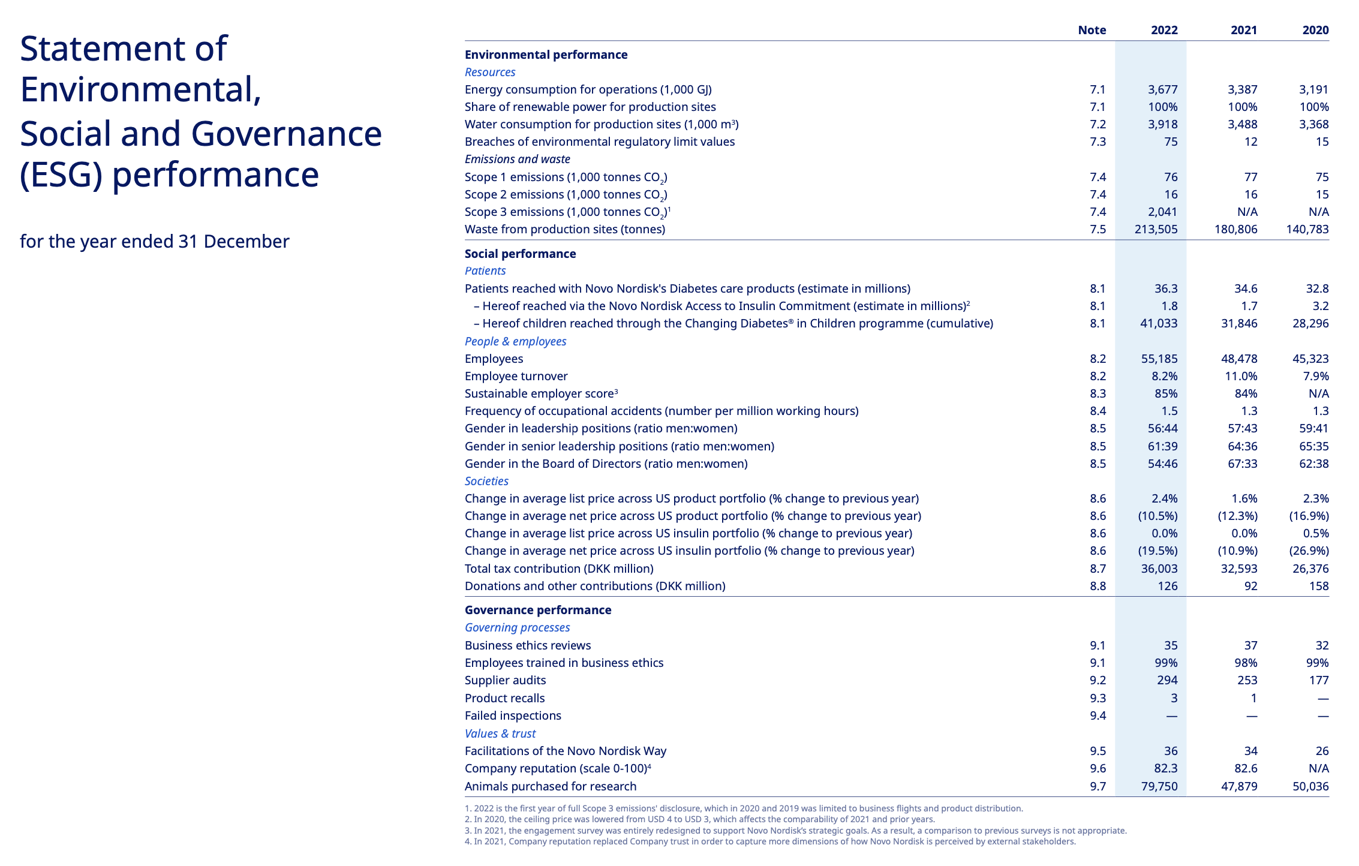

In [5]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="image.png")
file_path = "pix/answer.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

## Prepare image for the model

Preparing the image for the model can be done as follows:

In [6]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 510, 800])


## Forward pass

Next, we forward the pixel values through the model. The model outputs logits of shape (batch_size, num_queries, num_labels + 1). The +1 is for the "no object" class.

In [8]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [9]:
outputs.logits.shape

torch.Size([1, 15, 3])

## Postprocessing

Next, we take the prediction that has an actual class (i.e. not "no object").

In [10]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [11]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [12]:
print(objects)

[{'label': 'table', 'score': 0.999346911907196, 'bbox': [771.1853637695312, 31.097671508789062, 2220.335693359375, 1324.1446533203125]}]


## Visualize

We can visualize the detection on the image.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

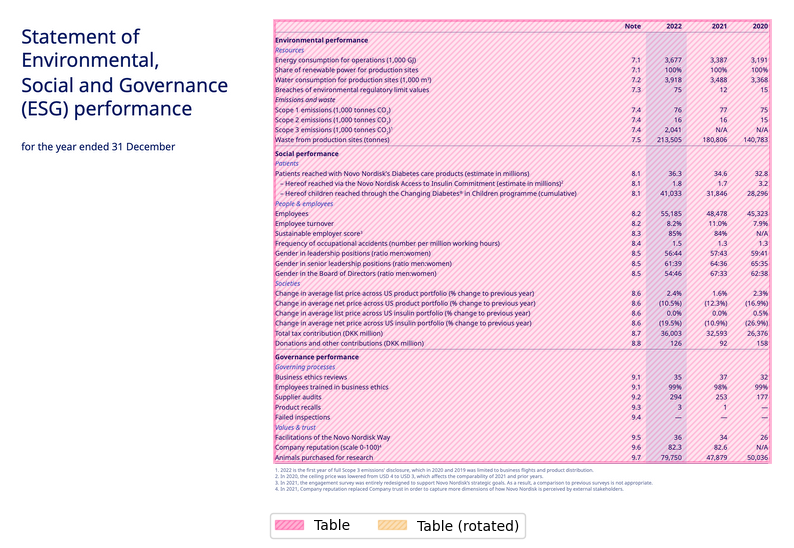

In [14]:
fig = visualize_detected_tables(image, objects)

In [15]:
visualized_image = fig2img(fig)

## Crop table

Next, we crop the table out of the image. For that, the TATR authors employ some padding to make sure the borders of the table are included.

In [16]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [17]:
objects

[{'label': 'table',
  'score': 0.999346911907196,
  'bbox': [771.1853637695312,
   31.097671508789062,
   2220.335693359375,
   1324.1446533203125]}]

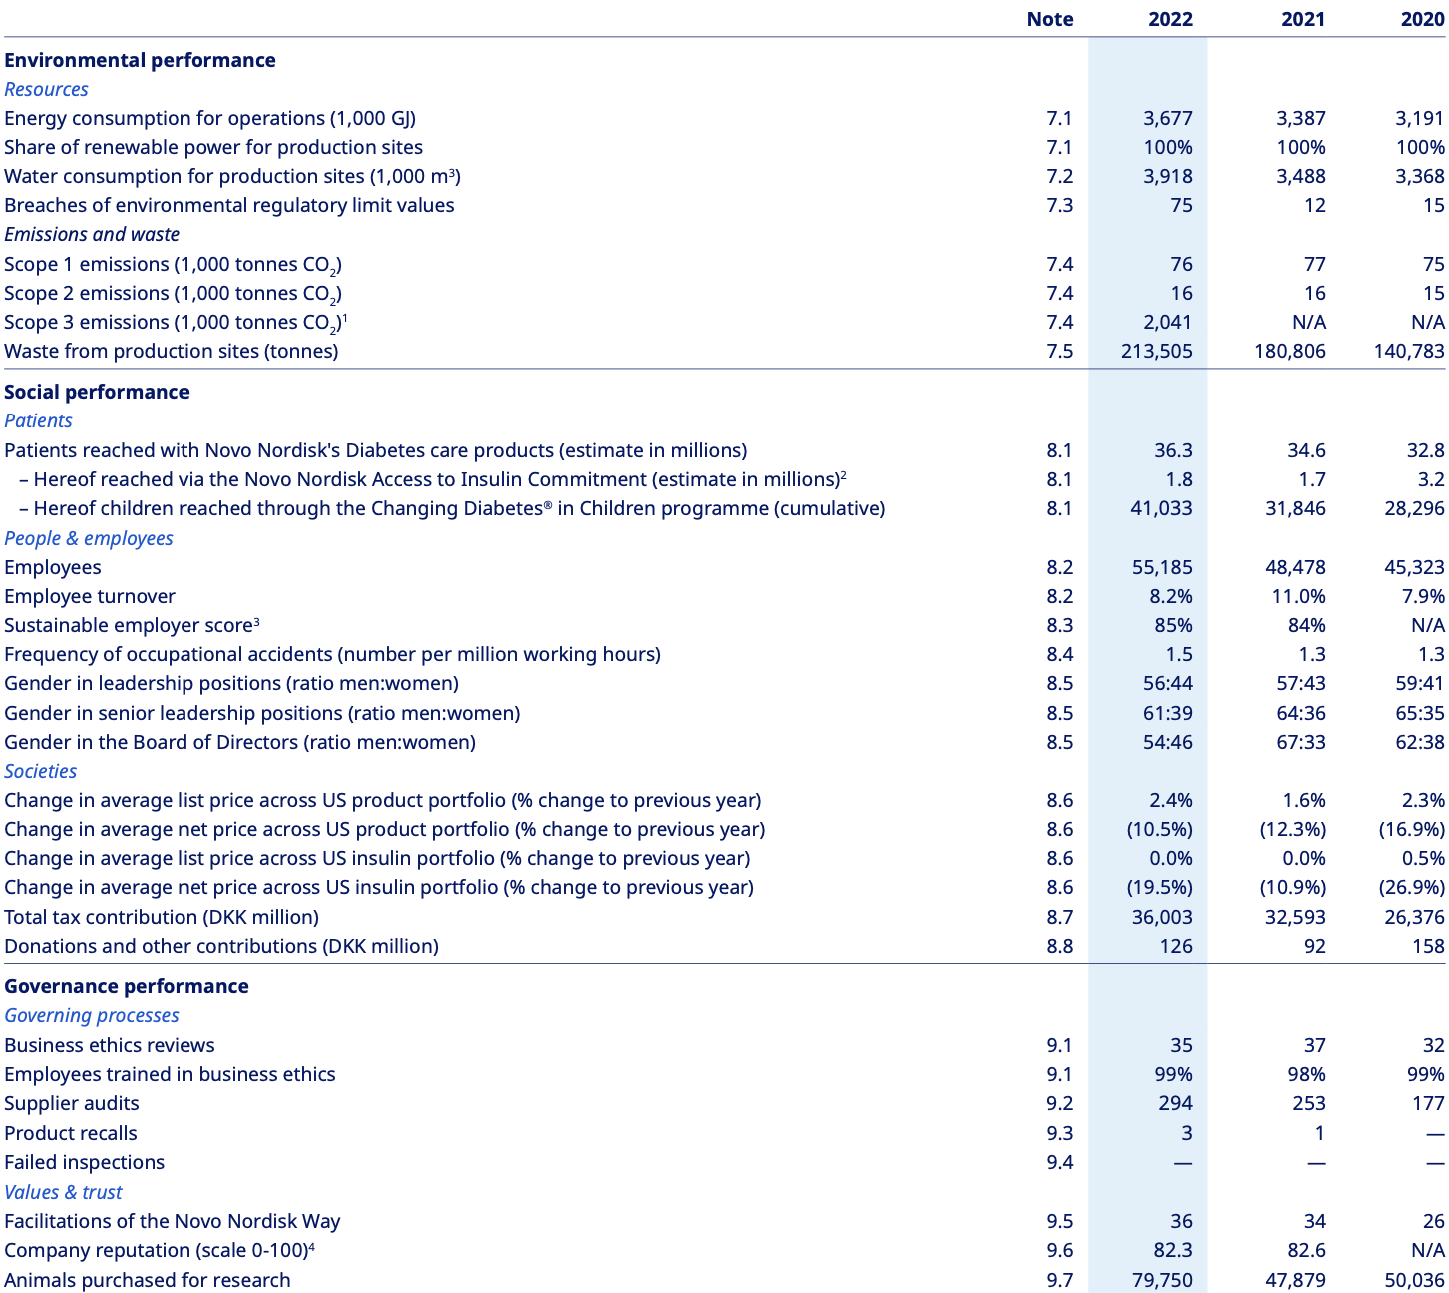

In [18]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [19]:
cropped_table.save("pix/table.jpg")

## Load structure recognition model

Next, we load a Table Transformer pre-trained for table structure recognition.

In [20]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

We prepare the cropped table image for the model, and perform a forward pass.

In [21]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 892, 1000])


In [23]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

Next, we get the predicted detections.

In [24]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table row', 'score': 0.9058967232704163, 'bbox': [2.0916824340820312, 800.9059448242188, 1445.570556640625, 831.2830810546875]}, {'label': 'table row', 'score': 0.9965840578079224, 'bbox': [1.9974989891052246, 306.0559387207031, 1445.4720458984375, 335.6214294433594]}, {'label': 'table projected row header', 'score': 0.7539820075035095, 'bbox': [2.1273951530456543, 522.335205078125, 1445.566162109375, 551.0841674804688]}, {'label': 'table projected row header', 'score': 0.9568629860877991, 'bbox': [2.296156406402588, 977.116455078125, 1446.202392578125, 1018.12353515625]}, {'label': 'table row', 'score': 0.9953591227531433, 'bbox': [1.9947352409362793, 1091.2095947265625, 1445.6826171875, 1120.4013671875]}, {'label': 'table row', 'score': 0.8386016488075256, 'bbox': [2.05912184715271, 585.3161010742188, 1445.5047607421875, 615.1268310546875]}, {'label': 'table row', 'score': 0.9971621632575989, 'bbox': [2.408822536468506, 103.5512466430664, 1445.59423828125, 132.54457092285

## Visualize cells

We can visualize all recognized cells using PIL's ImageDraw module.

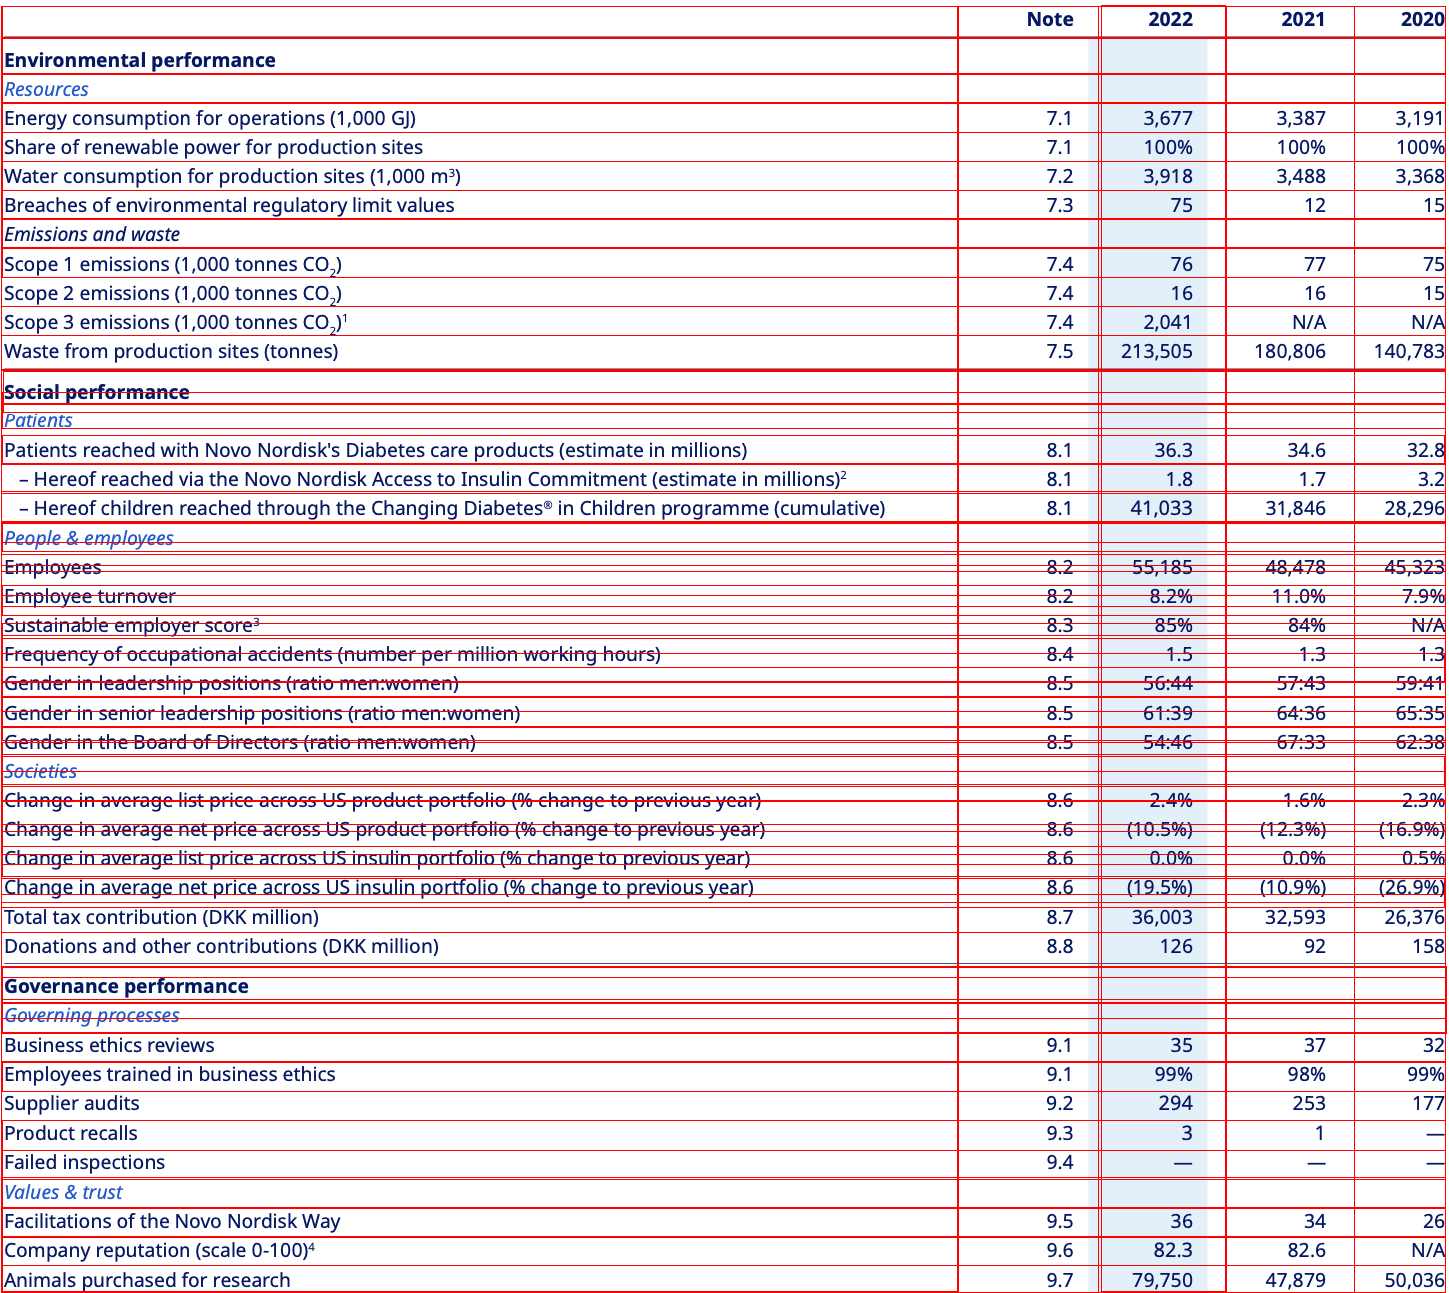

In [25]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

An alternative way of plotting is to select one class to visualize, like "table row":

In [26]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

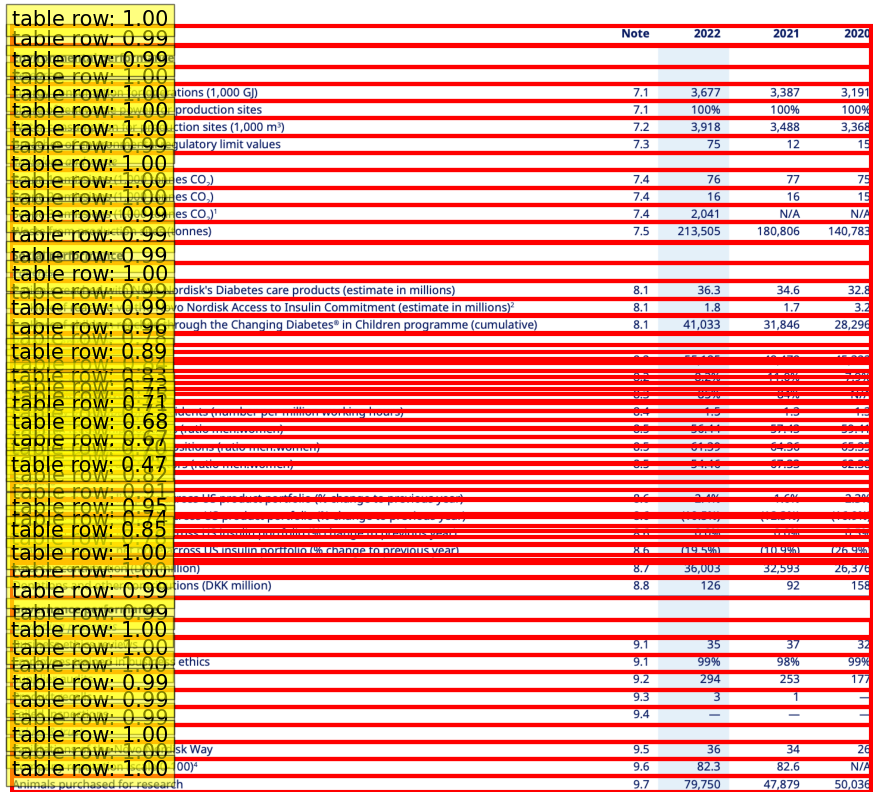

In [27]:
plot_results(cells, class_to_visualize="table row")

## Apply OCR row by row

First, we get the coordinates of the individual cells, row by row, by looking at the intersection of the table rows and columns (thanks ChatGPT!).

Next, we apply OCR on each individual cell, row-by-row.

Note that this makes some assumptions about the structure of the table: it assumes that the table has a rectangular, flat structure, containing a column header. One would need to update this for more complex table structures, potentially fine-tuning the detection and/or structure recognition model to be able to detect other layouts. Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better.

Alternatively, one could also do OCR column by column, etc.

In [28]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [29]:
len(cell_coordinates)

51

In [30]:
len(cell_coordinates[0]["cells"])

5

In [31]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [1.5402714014053345, 6.072328090667725, 958.1119384765625, 1291.690185546875], 'cell': [1.5402714014053345, 6.1449103355407715, 958.1119384765625, 37.862518310546875]}, {'column': [957.11767578125, 6.840627193450928, 1098.55078125, 1292.3148193359375], 'cell': [957.11767578125, 6.1449103355407715, 1098.55078125, 37.862518310546875]}, {'column': [1101.178466796875, 5.97294807434082, 1225.575927734375, 1291.9158935546875], 'cell': [1101.178466796875, 6.1449103355407715, 1225.575927734375, 37.862518310546875]}, {'column': [1226.8369140625, 6.393974781036377, 1354.115966796875, 1292.1943359375], 'cell': [1226.8369140625, 6.1449103355407715, 1354.115966796875, 37.862518310546875]}, {'column': [1354.0765380859375, 6.510426044464111, 1445.912841796875, 1292.5230712890625], 'cell': [1354.0765380859375, 6.1449103355407715, 1445.912841796875, 37.862518310546875]}]
[{'column': [1.5402714014053345, 6.072328090667725, 958.1119384765625, 1291.690185546875], 'cell': [1.5402714014053345, 3

In [32]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

  0%|          | 0/51 [00:00<?, ?it/s]

Max number of columns: 5
['Note', '2022', '2021', '2020', '']
['Environmental performance', '', '', '', '']
['Resources', '', '', '', '']
['Energy consumption for operations (1,000 GJ)', '7.1', '3,677', '3,387', '3,191']
['Share of renewable power for production sites', '7.1', '100%', '100%', '100%']
['Water consumption for production sites (1,000 m?)', '7.2', '3,918', '3,488', '3,368']
['Breaches of environmental julatory limit values regl', '73', '75', '12', '15']
['Emissions and waste', '', '', '', '']
['Scope emissions (1,000 tonnes CO_', '7.4', '76', '77', '75']
['Scope 2 emissions (1,000 tonnes CO', '7.4', '16', '16', '15']
['Scope 3 emissions (1,000 tonnes COz)"', '7.4', '2,041', 'NIA', 'NIA']
['Waste from production sites (tonnes)', '7.5', '213,505', '180,806', '140,783']
['Social performance', '', '', '', '']
['Patients', '', '', '', '']
["Patients reached with Novo Nordisk's Diabetes care products (estimate in millions)", '8.1', '36.3', '34.6', '32.8']
['Hereof reached via th

## Save as CSV

We end up with a CSV file containing the data.

In [33]:
import csv

with open('data/table.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [34]:
import pandas as pd

df = pd.read_csv("data/table.csv")
df.head(10)

,Note,2022,2021,2020,Unnamed: 4
0,Environmental performance,NaN,NaN,NaN,NaN
1,Resources,NaN,NaN,NaN,NaN
2,"Energy consumption for operations (1,000 GJ)",7.1,"3,677","3,387","3,191"
3,Share of renewable power for production sites,7.1,100%,100%,100%
4,"Water consumption for production sites (1,000 m?)",7.2,"3,918","3,488","3,368"
5,Breaches of environmental julatory limit value...,73,75,12,15
6,Emissions and waste,NaN,NaN,NaN,NaN
7,"Scope emissions (1,000 tonnes CO_",7.4,76,77,75
8,"Scope 2 emissions (1,000 tonnes CO",7.4,16,16,15
9,"Scope 3 emissions (1,000 tonnes COz)""",7.4,"2,041",NIA,NIA
